# Check-in 6: Neural Network

In [120]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

In [121]:
# load the dataset
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [122]:
# remove all rows with missing values
df.dropna(inplace=True) 

# remove all duplicate values based on track name and artist name
df.drop_duplicates(subset=['track_name', 'artists'], inplace=True)

In [ ]:
genres = ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
    'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
    'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
    'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
    'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
    'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
    'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
    'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
    'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
    'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
    'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
    'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
    'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
    'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
    'samba' 'sertanejo' 'show-tunes' 'singer-songwriter' 'ska' 'sleep'
    'songwriter' 'soul' 'spanish' 'study' 'swedish' 'synth-pop' 'tango'
    'techno' 'trance' 'trip-hop' 'turkish' 'world-music'
 ]

genre_mapping = {
    "rock_alt_metal": [
        "alt-rock", "alternative", "black-metal", "death-metal", "emo", "goth",
        "grindcore", "grunge", "hard-rock", "hardcore", "heavy-metal", "metal",
        "metalcore", "psych-rock", "punk-rock", "punk", "rock", "rock-n-roll", "hardstyle", "j-rock", "rockabilly"
    ],
    "pop_indie": [
        "pop", "power-pop", "pop-film", "indie", "indie-pop", "j-pop", "k-pop",
        "cantopop", "mandopop", "synth-pop"
    ],
    "electronic_dance": [
        "edm", "dance", "electro", "electronic", "trance", "techno",
        "detroit-techno", "chicago-house", "progressive-house", "deep-house",
        "house", "minimal-techno", "dubstep", "drum-and-bass", "breakbeat",
        "dub", "idm", "disco", "garage", "groove"
    ],
    "hiphop_rnb": [
        "hip-hop", "r-n-b", "soul", "funk"
    ],
    "jazz_classical": [
        "jazz", "blues", "classical", "piano"
    ],
    "country_folk": [
        "country", "folk", "bluegrass", "honky-tonk", "singer-songwriter",
        "songwriter", "acoustic"
    ],
    "latin_world": [
        "latin", "latino", "afrobeat", "brazil", "mpb", "samba", "salsa", "tango",
        "pagode", "forro", "sertanejo", "reggaeton", "indian", "iranian",
        "turkish", "french", "german", "british", "swedish", "malay", "world-music"
    ],
    "reggae": [
        "reggae", "dancehall"
    ],
    "ambient_chill": [
        "ambient", "chill", "new-age", "trip-hop"
    ],
    "thematic": [
        "anime", "children", "comedy", "club", "disney", "gospel", "guitar",
        "happy", "industrial", "j-dance", "j-idol", "kids", "opera", "party",
        "romance", "sad", "show-tunes", "ska", "sleep", "spanish", "study"
    ]
}


flattened_mapping = {genre: category for category, subgenres in genre_mapping.items() for genre in subgenres}

# create a dictionary with keys being numbers 0-9 and the values being each key in genre_mapping
genres = [genre for genre, _ in genre_mapping.items()]
genre_encoding = {genre: i for i, genre in enumerate(genres)}

print(genre_encoding)

df['track_genre'] = df['track_genre'].apply(lambda x: flattened_mapping[x])


# genre_encoded
df_encoded = df
df_encoded['track_genre'] = df_encoded['track_genre'].apply(lambda x: genre_encoding[x])

# shuffle the dataframe
df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)

# separate the features and the target variable (track_genre) and convert to tensors
X = torch.tensor(df_encoded.drop(columns=['track_genre']).select_dtypes(include=[np.number]).to_numpy(), dtype=torch.float32)
y = torch.tensor(df_encoded['track_genre'].to_numpy(), dtype=torch.long)

print(X.shape, y.shape)



{'rock_alt_metal': 0, 'pop_indie': 1, 'electronic_dance': 2, 'hiphop_rnb': 3, 'jazz_classical': 4, 'country_folk': 5, 'latin_world': 6, 'reggae': 7, 'ambient_chill': 8, 'thematic': 9}
torch.Size([81343, 15]) torch.Size([81343])


### create dataset, split

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

In [124]:
class Track_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [125]:
# split the dataset into train, valid, and test sets
train_size = int(0.7 * len(df))
valid_size = int(0.15 * len(df))
test_size = len(df) - train_size - valid_size
X_train, X_valid, X_test = torch.split(X, [train_size, valid_size, test_size])
print(X_train.shape, X_valid.shape, X_test.shape)
y_train, y_valid, y_test = torch.split(y, [train_size, valid_size, test_size])
print(y_train.shape, y_valid.shape, y_test.shape)


train_dataset = Track_dataset(X_train, y_train)
valid_dataset = Track_dataset(X_valid, y_valid)
test_dataset = Track_dataset(X_test, y_test)

torch.Size([56940, 15]) torch.Size([12201, 15]) torch.Size([12202, 15])
torch.Size([56940]) torch.Size([12201]) torch.Size([12202])


### define model

In [169]:
# 1d CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        x = x.view(64, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### train the model

In [176]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# train the model, record the validation loss for the plots
n_epochs = 10
train_loss_hist, valid_loss_hist = [], []
for epoch in range(n_epochs):
    tot_train_loss, tot_valid_loss = 0, 0

    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        tot_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        tot_valid_loss = 0
        for x, y in valid_loader:
            y_pred = model(x)
            valid_loss = criterion(y_pred, y)
            tot_valid_loss += valid_loss.item()
        print(f"Epoch {epoch}: Validation Loss: {tot_valid_loss/len(valid_loader)}")
    train_loss_hist.append(tot_train_loss/len(train_loader))
    valid_loss_hist.append(tot_valid_loss/len(valid_loader))

Epoch 0: Validation Loss: 2.202393500428451
Epoch 1: Validation Loss: 2.0643985773387707
Epoch 2: Validation Loss: 2.0208921871687235
Epoch 3: Validation Loss: 2.0131726170841016
Epoch 4: Validation Loss: 2.0099976395305834
Epoch 5: Validation Loss: 2.0100855632832175
Epoch 6: Validation Loss: 2.0099416977480837
Epoch 7: Validation Loss: 2.009982823070727
Epoch 8: Validation Loss: 2.0100166565493534
Epoch 9: Validation Loss: 2.0100755898576033


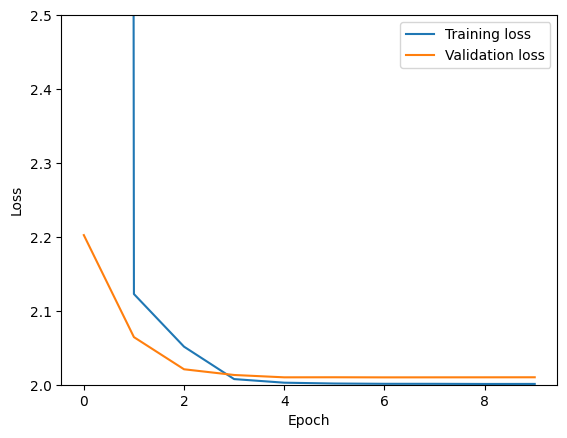

In [180]:
# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, label='Training loss')
plt.plot(valid_loss_hist, label='Validation loss')
# set the x-axis to be in terms of epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
# set the y-axis max to 400
plt.ylim(2, 2.5)
plt.legend()
plt.show()

In [182]:
# test the model
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        y_pred = model(x)
        test_loss += criterion(y_pred, y)
        _, predicted = torch.max(y_pred, 1)
        # print(predicted)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    print(f"Test Loss: {test_loss.item()}")
    print(f"Test Accuracy: {correct / total}")

Test Loss: 379.9164123535156
Test Accuracy: 0.21480263157894736
